In [1]:
import pandas as pd
import numpy as np
np.random.seed(10)
import pandas_profiling as pp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn import svm

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight

from os import cpu_count

from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = 12, 8

pd.options.display.width = 500
n_jobs = max(cpu_count()-1, 1)

In [628]:
train = pd.read_csv("../../data/modulbank/train.csv", sep='\t')
test = pd.read_csv("../../data/modulbank/test.csv", sep='\t')

In [10]:
profile = pp.ProfileReport(train)
profile.to_file(outputfile="statistic_train.html")

In [11]:
profile = pp.ProfileReport(test)
profile.to_file(outputfile="statistic_test.html")

In [324]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30500 entries, 0 to 30499
Columns: 346 entries, 0 to 345
dtypes: float64(106), int64(240)
memory usage: 80.5 MB


In [323]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4166 entries, 0 to 4165
Columns: 347 entries, _ID_ to 345
dtypes: float64(107), int64(240)
memory usage: 11.0 MB


In [629]:
train.drop('Unnamed: 0', axis=1, inplace=True)
test.rename({'Unnamed: 0':'_ID_'}, axis=1, inplace=True)


### Split data

In [227]:
X = train.drop('0', axis=1)
y = train['0']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  stratify=y)

### Baseline on Logregression

In [8]:
X = train.drop('0', axis=1)
y = train['0']

In [10]:
y.value_counts(normalize=True)

0    0.822197
1    0.177803
Name: 0, dtype: float64

In [49]:
lr = LogisticRegression(tol=0.9, 
                        C=100, 
                        random_state=42,
                        solver='newton-cg', 
                        class_weight='balanced')
lr.fit(X_train,  y_train)
roc_auc_score(y_val, lr.predict(X_val))

0.664266647063418

### Baseline Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, 
                            random_state=42,
                            min_samples_leaf=7,
                            min_samples_split=10, 
                            class_weight='balanced')
rf.fit(X_train,  y_train)
roc_auc_score(y_val, rf.predict(X_val))

0.6364886906101971

### Baseline on LGBm

In [619]:
lable_weights = class_weight.compute_class_weight('balanced', train['0'].unique(), 
                                                  train['0'].values)
lable_weights = dict(zip([0,1],lable_weights))
lable_weights

{0: 2.8113085322968723, 1: 0.6081638372837924}

In [225]:
train['weights'] = train['0'].map(lable_weights)

In [79]:
train.drop('weights', axis=1, inplace=True)

In [228]:
lgb_train = lgb.Dataset(X_train.drop(['weights'], axis=1), 
                       y_train, weight=X_train.weights.values)
lgb_eval = lgb.Dataset(X_val.drop(['weights'], axis=1), 
                       y_val, reference=lgb_train, weight=X_val.weights.values)

In [229]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'metric': {'l2', 'auc'},
    'num_leaves': 40,
    'learning_rate': 0.005,
    'feature_fraction': 0.55,
    'bagging_fraction': 0.55,
    'bagging_freq': 6
}

print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=15,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

Start training...
[1]	valid_0's l2: 0.0427033	valid_0's auc: 0.682564
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0426865	valid_0's auc: 0.685161
[3]	valid_0's l2: 0.0426678	valid_0's auc: 0.702075
[4]	valid_0's l2: 0.0426478	valid_0's auc: 0.705261
[5]	valid_0's l2: 0.0426291	valid_0's auc: 0.707257
[6]	valid_0's l2: 0.042612	valid_0's auc: 0.708679
[7]	valid_0's l2: 0.0425953	valid_0's auc: 0.711872
[8]	valid_0's l2: 0.0425791	valid_0's auc: 0.716703
[9]	valid_0's l2: 0.042561	valid_0's auc: 0.715687
[10]	valid_0's l2: 0.0425444	valid_0's auc: 0.715968
[11]	valid_0's l2: 0.0425298	valid_0's auc: 0.715553
[12]	valid_0's l2: 0.0425136	valid_0's auc: 0.715395
[13]	valid_0's l2: 0.0424996	valid_0's auc: 0.715714
Early stopping, best iteration is:
[8]	valid_0's l2: 0.0425791	valid_0's auc: 0.716703


(array([5.082e+03, 5.720e+02, 2.550e+02, 9.200e+01, 3.900e+01, 1.400e+01,
        7.000e+00, 6.000e+00, 6.000e+00, 3.000e+00]),
 array([0.04379589, 0.04611825, 0.04844062, 0.05076298, 0.05308534,
        0.05540771, 0.05773007, 0.06005243, 0.0623748 , 0.06469716,
        0.06701952]),
 <a list of 10 Patch objects>)

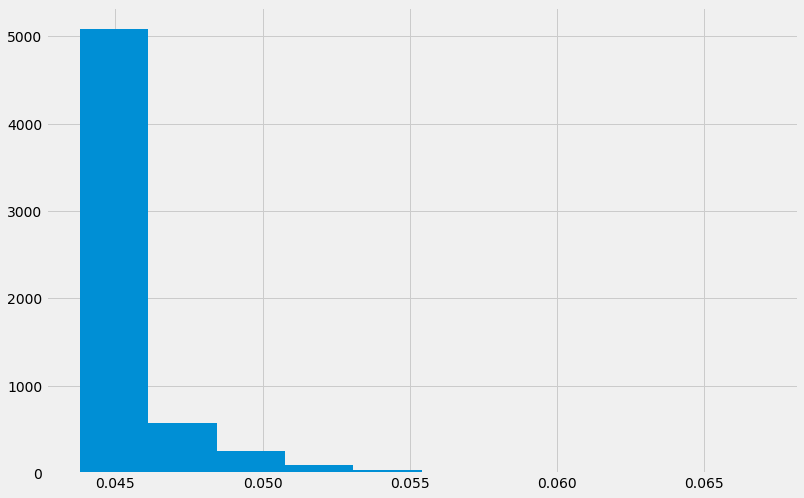

In [235]:
plt.hist(gbm.predict(X_val))

In [245]:
def mround(x):
    if x > 0.0451:
        return 1
    return 0

Counter([ mround(x) for x in gbm.predict(X_val)  ]) 

Counter({0: 5052, 1: 1024})

In [260]:
roc_auc_score(y_val, [ mround(x) for x in gbm.predict(X_val)  ])

0.6606451965378884

### Filter constans from test

In [630]:
filter_test_const_cols = ['129', '130', '137', '138', '303', '305',
                          '5', '141', '149', '150', '164', '178', '186', '188',
                          '192', '291', '301']

print(train.shape)
for col in filter_test_const_cols:
    train = train[train[col] == 0].drop(col, axis=1)
#     print(train.shape)

(30500, 346)


In [631]:
print(test.shape)

train = train[train['11'] == 1].drop('11', axis=1)
test.drop(filter_test_const_cols + ['11'], axis=1, inplace=True)
print(test.shape, train.shape)

(4166, 347)
(4166, 329) (30379, 328)


### Remove constant from train

In [636]:
remove_const_cols = ['140', '152', '160']

train.drop(remove_const_cols, axis=1, inplace=True)
test.drop(remove_const_cols, axis=1, inplace=True)
print(train.shape, test.shape)

In [336]:
lr = LogisticRegression(tol=0.9, C=100, random_state=42, solver='newton-cg', class_weight='balanced')
lr.fit(X_train,  y_train)
roc_auc_score(y_val, lr.predict(X_val))

0.6800444292581204

In [73]:
rf = RandomForestClassifier(n_estimators=250, 
                            random_state=42,
                            min_samples_leaf=7,
                            min_samples_split=15, 
                            class_weight='balanced',
                            max_features='log2')

rf.fit(X_train,  y_train)
roc_auc_score(y_val, rf.predict(X_val))

0.6453053423451204

## Remove zeros cols

In [132]:
zero_cols = ['66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
             '77', '78', '79', '80', '81', '82', '83', '84', '85', '86',
            '87', '88', '89', '90', '91']


In [137]:
X.drop(zero_cols, axis=1, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y,
                                                   test_size=0.2, 
                                                   random_state=42,
                                                stratify=y)

In [101]:
lr = LogisticRegression(tol=0.9, C=100, 
                        random_state=42,
                        solver='newton-cg',
                        class_weight='balanced',
                        n_jobs=n_jobs)

lr.fit(X_train,  y_train)
roc_auc_score(y_val, lr.predict(X_val))

0.677994090297513

In [138]:
rf = RandomForestClassifier(n_estimators=250, 
                            random_state=42,
                            min_samples_leaf=7,
                            min_samples_split=15, 
                            class_weight='balanced',
                            max_features='log2')

rf.fit(X_train,  y_train)
roc_auc_score(y_val, rf.predict(X_val))

0.6476456104578213

### Corr features

In [108]:
corr_features = ['9', '2', '341', '311', '335', '334', '333', '327',
                 '325', '326', '324', '323', '319', '204', '206', '26', '180',
                 '179', '24', '165', '22', '158', '20', '17', '153', '148', '39',
                 '35', '146', '122', '119', '115', '110', '117']

print(len(corr_features))
print(sorted(corr_features))

34
['110', '115', '117', '119', '122', '146', '148', '153', '158', '165', '17', '179', '180', '2', '20', '204', '206', '22', '24', '26', '311', '319', '323', '324', '325', '326', '327', '333', '334', '335', '341', '35', '39', '9']


In [637]:
del_corr = ['165', '180', '9', '153']
train.drop(del_corr, axis=1, inplace=True)
test.drop(del_corr, axis=1, inplace=True)

In [640]:
X = train.drop('0', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y,
                                                   test_size=0.2, 
                                                   random_state=42,
                                                stratify=y)

In [528]:
lr = LogisticRegression(tol=0.9, C=100, 
                        random_state=42,
                        solver='newton-cg',
                        class_weight='balanced',
                        n_jobs=n_jobs)

lr.fit(X_train,  y_train)
roc_auc_score(y_val, lr.predict(X_val))

0.6806070640483222

In [159]:
rf = RandomForestClassifier(n_estimators=250, 
                            random_state=42,
                            min_samples_leaf=7,
                            min_samples_split=15, 
                            class_weight='balanced',
                            max_features='log2')

rf.fit(X_train,  y_train)
roc_auc_score(y_val, rf.predict(X_val))

0.6468689781363232

In [121]:
from sklearn.decomposition import PCA
X = PCA(2).fit_transform(X)

colours = ['blue', 'red', 'green']
n = 300
plt.xlim(-10, 20)
plt.ylim(-10, 11)

plt.scatter(X[:n, 0].reshape(n), X[:n, 1].reshape(n),
            color=[colours[int(i)-1] for i in y.unique()])

## Add features:

- std(by all columns for each user)
- count of unique values
-- (?for LR)

### Try ExtraTreesClassifier

In [641]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=120,
                              random_state=0,
                              max_depth=15,
                              max_features='sqrt',
                              n_jobs=3, 
                              class_weight='balanced' )

forest.fit(X_train,  y_train)
roc_auc_score(y_val, forest.predict(X_val))

0.6807378145953539

### Feature importances

Feature ranking:
1. feature 94 (0.015871)
2. feature 101 (0.014819)
3. feature 98 (0.014795)
4. feature 97 (0.014583)
5. feature 102 (0.014514)
6. feature 103 (0.014380)
7. feature 100 (0.014231)
8. feature 104 (0.014055)
9. feature 99 (0.011299)
10. feature 96 (0.011215)
11. feature 189 (0.011080)
12. feature 95 (0.010039)
13. feature 191 (0.009729)
14. feature 172 (0.009331)
15. feature 121 (0.009249)
16. feature 122 (0.009197)
17. feature 179 (0.009094)
18. feature 119 (0.009009)
19. feature 110 (0.009001)
20. feature 107 (0.008944)
21. feature 173 (0.008900)
22. feature 319 (0.008867)
23. feature 186 (0.008835)
24. feature 105 (0.008830)
25. feature 90 (0.008789)
26. feature 108 (0.008780)
27. feature 183 (0.008733)
28. feature 111 (0.008721)
29. feature 187 (0.008659)
30. feature 174 (0.008639)
31. feature 177 (0.008636)
32. feature 89 (0.008623)
33. feature 181 (0.008622)
34. feature 178 (0.008595)
35. feature 182 (0.008530)
36. feature 184 (0.008515)
37. feature 185 (0.008508)
3

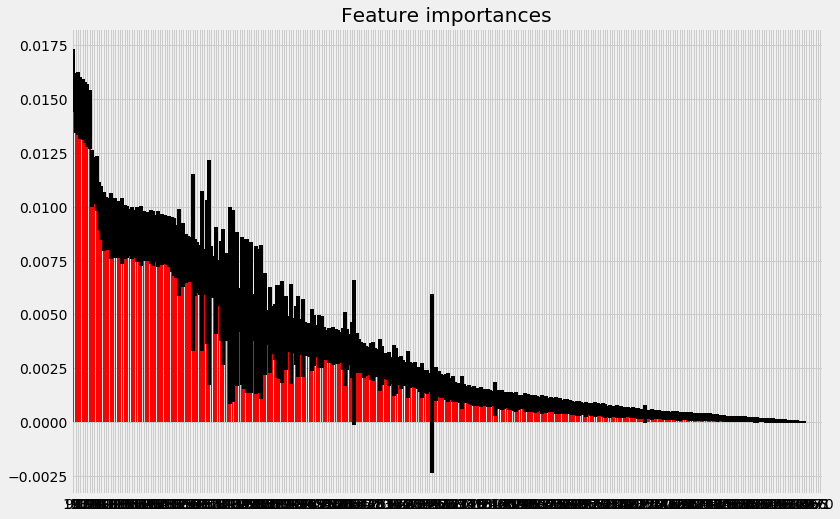

In [162]:
from sklearn.ensemble import ExtraTreesClassifier
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0, )

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
most_important_feature = dict()
for f in range(X.shape[1]):
    most_important_feature[X.columns[f]] = importances[indices[f]]
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Build LR in top 80, 100 .. features

In [179]:
from collections import Counter
most_im_fc = Counter(most_important_feature)
most_important_features = np.array([p[0] for p in most_im_fc.most_common(80)])

In [180]:
lr = LogisticRegression(tol=0.9, C=100, 
                        random_state=42,
                        solver='newton-cg',
                        class_weight='balanced',
                        n_jobs=n_jobs)

lr.fit(X_train[most_important_features],  y_train)
roc_auc_score(y_val, lr.predict(X_val[most_important_features]))

0.6384372346444501

### Try bagging

In [587]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(LogisticRegression(class_weight= 'balanced',
                                               tol=0.9, C=1., 
                                               random_state=42,
                                               solver='newton-cg',
                                               n_jobs=n_jobs),
                             max_samples=0.65,
                             max_features=0.70,
                             n_estimators=15, 
                             random_state=42)

In [588]:
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=3, penalty='l2', random_state=42,
          solver='newton-cg', tol=0.9, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.7,
         max_samples=0.65, n_estimators=15, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [589]:
roc_auc_score(y_val, bagging.predict(X_val))

0.6777489793215973

### Simple ansemble

In [690]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
et = forest
rf_predictions = []
et_predictions = []

for train, val in skf.split(X, y):
#     print(train, val)
    rf.fit(X.iloc[train], y.iloc[train])
    et.fit(X.iloc[train], y.iloc[train])
    rf_predictions.append([y.iloc[val], rf.predict_proba(X.iloc[val])[:,1]])
    et_predictions.append([y.iloc[val], et.predict_proba(X.iloc[val])[:,1]])

In [712]:

lr_predictions = []
et_predictions = []

for train, val in skf.split(X, y):

    lr.fit(X.iloc[train], y.iloc[train])
    et.fit(X.iloc[train], y.iloc[train])
    lr_predictions.append([y.iloc[val], lr.predict_proba(X.iloc[val])[:,1]])
    et_predictions.append([y.iloc[val], et.predict_proba(X.iloc[val])[:,1]])

In [699]:
# RF + ExtraTrees
np.mean([roc_auc_score(i[0], i[1]) for i in rf_predictions]), np.mean([roc_auc_score(i[0], i[1]) for i in et_predictions])

(0.721651559159803, 0.7273380384433615)

In [693]:
#  LR + ExtraTrees

np.mean([roc_auc_score(i[0], i[1]) for i in lr_predictions]), np.mean([roc_auc_score(i[0], i[1]) for i in et_predictions])

(0.6764517243496013, 0.7273380384433615)


### Simple averaging

In [700]:
# RF + ExtraTrees
np.mean([roc_auc_score(rf_p[0], rf_p[1]*0.5 + et_p[1]*0.5) for rf_p, et_p in zip(rf_predictions, et_predictions)])

0.7341359831780601

In [694]:
#  LR + ExtraTrees

np.mean([roc_auc_score(rf_p[0], rf_p[1]*0.5 + et_p[1]*0.5) for rf_p, et_p in zip(rf_predictions, et_predictions)])

0.7221105389896744

### Geometric mean

In [701]:
# RF + ExtraTrees
np.mean([roc_auc_score(rf_p[0], np.sqrt(rf_p[1]*et_p[1])) for rf_p, et_p in zip(rf_predictions, et_predictions)])

0.7339171479070217

In [695]:
#  LR + ExtraTrees

np.mean([roc_auc_score(rf_p[0], np.sqrt(rf_p[1]*et_p[1])) for rf_p, et_p in zip(lr_predictions, et_predictions)])

0.7153872684623916

### Rank avarage

In [696]:
from scipy.stats import rankdata
# RF + ExtraTrees
np.mean([roc_auc_score(rf_p[0], rankdata(rf_p[1]) + rankdata(et_p[1])) for rf_p, et_p in zip(rf_predictions, et_predictions)])

0.7124336555659387

In [702]:
#  LR + ExtraTrees
np.mean([roc_auc_score(rf_p[0], rankdata(rf_p[1]) + rankdata(et_p[1])) for rf_p, et_p in zip(lr_predictions, et_predictions)])

0.7346453280525592

### Comparison different models

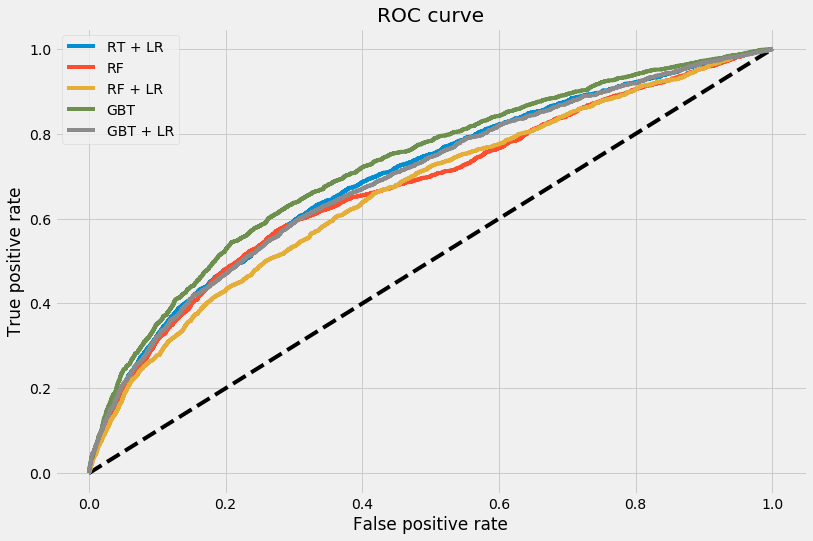

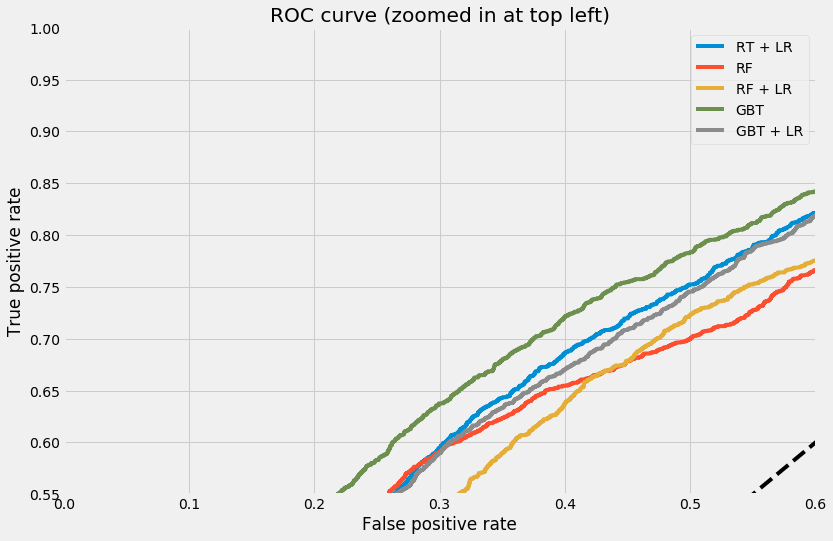

In [643]:
n_estimator = 80
state=42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.2, 
                                                            stratify=y_train,
                                                            random_state=state)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3,
                          n_estimators=n_estimator,
                          random_state=state)

rt_lm = LogisticRegression(random_state=state)
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, random_state=state)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(random_state=state)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

grd = GradientBoostingClassifier(n_estimators=n_estimator, random_state=state)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(random_state=state)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.6)
plt.ylim(0.55, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### Try Gradient Boosting

In [502]:
grd = GradientBoostingClassifier(n_estimators=50,
                                 max_features='log2', random_state=42)

grd.fit(X_train, y_train ) 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [513]:
def mround2(x):
    if x[1] > 0.2159:
        return 1
    return 0

roc_auc_score(y_val, [mround2(x) for x in grd.predict_proba(X_val)])

0.6729678799984072

(array([1307., 2192., 1191.,  526.,  428.,  230.,  122.,   50.,   20.,
          10.]),
 array([0.05768313, 0.11215597, 0.16662882, 0.22110166, 0.2755745 ,
        0.33004735, 0.38452019, 0.43899304, 0.49346588, 0.54793873,
        0.60241157]),
 <a list of 10 Patch objects>)

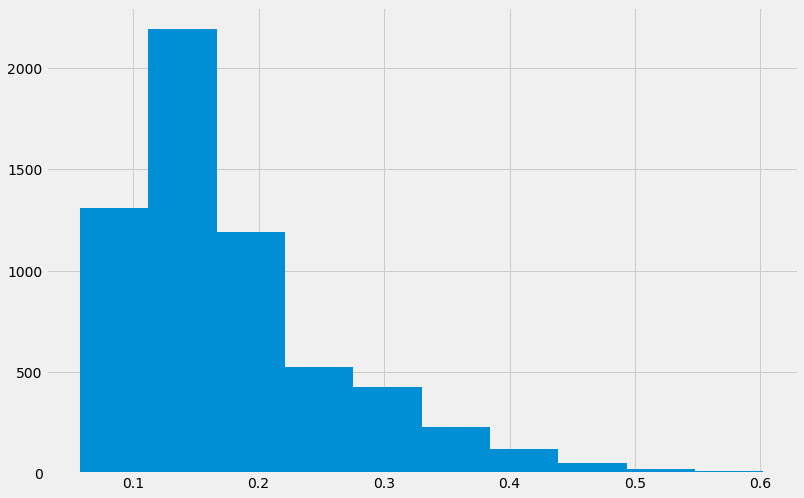

In [515]:
plt.hist(grd.predict_proba(X_val)[:, 1])

To be continued..

### Predict test

In [649]:
test.drop('0', axis=1, inplace=True)

In [644]:
def to_submission(predictions, filename):
    result = pd.Series(predictions, name='_VAL_')
    result.to_csv(filename, header=True, index_label='_ID_')

In [650]:
final_predict = bagging.predict(test.drop(['_ID_'], axis=1))
to_submission(final_predict, 'bagging.csv')